<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Deep-Learning project</h1></center>
<center><h2>Face mask detection</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


We will work with the dataset **```Face Mask Dataset```**. This dataset contains images of people with and without face masks to protect against Covid-19.

> The structure of the exercise is as follows: 
>> I - [Processing the dataset](#preparation)
>>> A - [Data importation and visualization](#affichage)
>>>
>>>
>>> B - [Generators](#generateurs)
>>
>>
>> II - [Classification](#classif)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16

# I - <a name="preparation"></a> Processing the dataset

## A - <a name="affichage"></a> Data importation and visualization

In [2]:
with_mask = "Face Mask Dataset/Train/WithMask"
without_mask = "Face Mask Dataset/Train/WithoutMask"

paths_with_mask = [join(with_mask, f) for f in listdir(with_mask) if isfile(join(with_mask, f))]
paths_without_mask = [join(without_mask, f) for f in listdir(without_mask) if isfile(join(without_mask, f))]

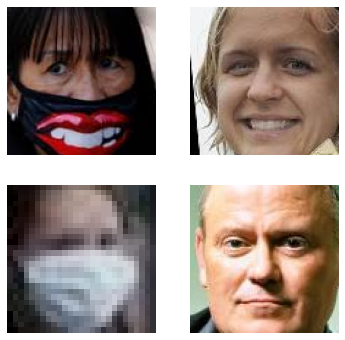

In [3]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis("off")
plt.imshow(image.imread(paths_with_mask[np.random.randint(len(paths_with_mask))]))

plt.subplot(222)
plt.axis("off")
plt.imshow(image.imread(paths_without_mask[np.random.randint(len(paths_without_mask))]))

plt.subplot(223)
plt.axis("off")
plt.imshow(image.imread(paths_with_mask[np.random.randint(len(paths_with_mask))]))

plt.subplot(224)
plt.axis("off")
plt.imshow(image.imread(paths_without_mask[np.random.randint(len(paths_without_mask))]));

## B - <a name="generateurs"></a> Generators

In [4]:
train_data_generator = ImageDataGenerator(validation_split=0.2,                      
                                          rotation_range=15,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True)

valid_data_generator = ImageDataGenerator(validation_split=0.2)

test_data_generator  = ImageDataGenerator()

In [5]:
training_data = train_data_generator.flow_from_directory(directory="Face Mask Dataset/Train",
                                                         target_size=(224, 224),
                                                         class_mode="binary",
                                                         batch_size=32)

valid_data = valid_data_generator.flow_from_directory(directory="Face Mask Dataset/Validation",
                                                      target_size=(224, 224),
                                                      class_mode="binary",
                                                      batch_size=32)

test_data = test_data_generator.flow_from_directory(directory="Face Mask Dataset/Test",
                                                    target_size=(224, 224),
                                                    class_mode="binary",
                                                    batch_size=1)

Found 654 images belonging to 2 classes.
Found 183 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


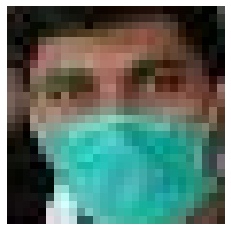

In [6]:
image_to_augment = image.imread(paths_with_mask[np.random.randint(len(paths_with_mask))])

plt.imshow(image_to_augment)
plt.axis("off");

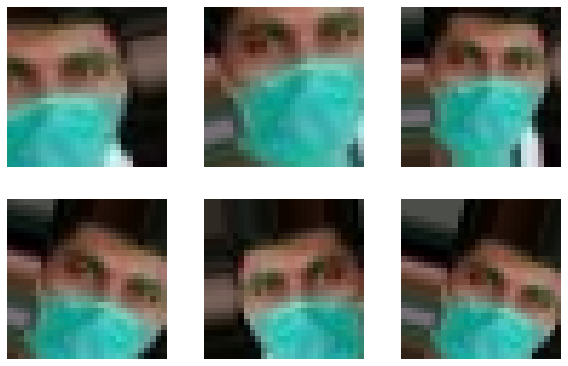

In [7]:
gen = train_data_generator.flow(np.expand_dims(image_to_augment, axis=0), batch_size=1)

plt.figure(figsize=(10, 10))

for i in range(6):
  plt.subplot(330 + 1 + i)
  batch = gen.next()
  img = batch[0]
  plt.imshow(img)
  plt.axis("off");

# II - <a name="classif"></a> Classification

In [9]:
# VGG16 model
base_model = VGG16(weights="imagenet", include_top=False) 
# Freezer the layers of VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Add VGG16
model.add(GlobalAveragePooling2D()) 
model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation="relu"))
model.add(Dense(units=32, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [10]:
early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         patience=7,
                                         mode="min",
                                         restore_best_weights=True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                         patience=5,
                                         factor=0.5,
                                         verbose=2,
                                         mode="min",
                                         min_lr=1e-10)

In [11]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

In [12]:
history = model.fit(training_data, validation_data=valid_data, epochs=30, callbacks=[early_stopping,lr_plateau])

Epoch 1/30
21/21 [==============================] - 16s 527ms/step - loss: 0.7872 - accuracy: 0.7202 - val_loss: 0.2183 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 8s 360ms/step - loss: 0.2302 - accuracy: 0.9174 - val_loss: 0.2017 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 8s 357ms/step - loss: 0.1691 - accuracy: 0.9327 - val_loss: 0.1350 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 8s 362ms/step - loss: 0.1381 - accuracy: 0.9633 - val_loss: 0.1277 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 5/30
21/21 [==============================] - 8s 357ms/step - loss: 0.1332 - accuracy: 0.9511 - val_loss: 0.0901 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 6/30
21/21 [==============================] - 7s 354ms/step - loss: 0.0724 - accuracy: 0.9817 - val_loss: 0.0913 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 7/30
21/21 [==============================] - 8s 356ms/step - l

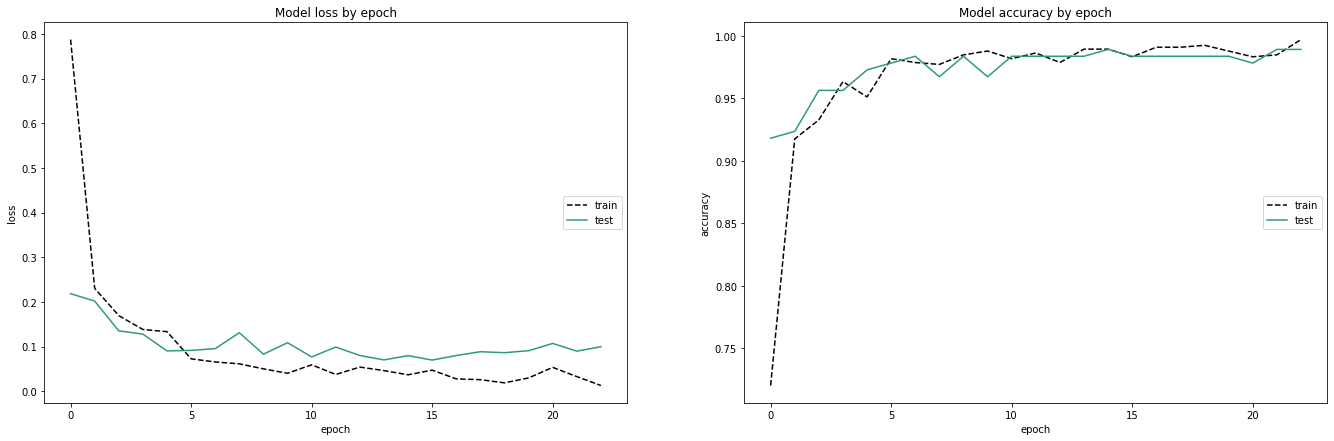

In [13]:
plt.figure(figsize=(23, 7))

plt.subplot(121)
plt.plot(history.history["loss"], "k--")
plt.plot(history.history["val_loss"], color="#2e9a74")
plt.title("Model loss by epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="right")

plt.subplot(122)
plt.plot(history.history["accuracy"], "k--")
plt.plot(history.history["val_accuracy"], color="#2e9a74")
plt.title("Model accuracy by epoch")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="right");

In [14]:
model.evaluate(test_data)

166/166 [==============================] - 1s 6ms/step - loss: 0.0271 - accuracy: 0.9940


[0.027102285996079445, 0.9939758777618408]

In [15]:
model.save("face_mask_detector.h5")